In [1]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks import Callback
from lightning.pytorch import loggers as pl_loggers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from models import LitAE, LitPredictor
from models import L1Loss
from utils import LitDataModule, VisCallbackAE, save_code_cfg, get_dataloader

import numpy as np
from hydra import compose, initialize
from omegaconf import OmegaConf
from matplotlib import pyplot as plt

initialize(config_path="./configs")
cfg = compose(config_name="config_DMBN_VFP_NPVP-S")
cfg.Env.strategy = 'dp'

pl.seed_everything(cfg.Env.rand_seed, workers=True)

/home/mfedozzi/anaconda3/envs/npvp-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_235107/1949169011.py:19: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="./configs")
Global seed set to 3047


3047

In [2]:
def plot_model_result(pred_list, fig_name, num_frames, n = 2):
    fig, axes = plt.subplots(len(pred_list), num_frames, figsize = (num_frames, len(pred_list)))
    fig.subplots_adjust(wspace=0., hspace = 0.)

    for ax, pred in zip(axes, pred_list):
        for j in range(num_frames):
            ax[j].set_axis_off()
            
            img = pred[:, j, :, :, :].clone()
            img = renorm_transform(img) # type: ignore
            img = torch.clamp(img, min = 0., max = 1.)
            img = img[n, ...]

            img = transforms.ToPILImage()(img)
            ax[j].imshow(img) #, cmap = 'gray')
    #fig.savefig(f'{fig_name}.pdf', bbox_inches = 'tight')

def inference(sample, to_list, tp_list, predictor, gray_scale = True):
    p, f = sample
    full_frame = torch.cat([p, f], dim = 1).to('cuda:0')
    p = full_frame[:, to_list.to(torch.long), ...]
    try:
        f = full_frame[:, tp_list.to(torch.long), ...]
    except:
        f = None
    predictor.predictor.reset_pos_coor(to_list, tp_list)
    predictor = predictor.eval()
    with torch.no_grad():
        rec_past_frames, rec_future_frames, pred = predictor(p.clone())
        
    return p, f, pred

In [3]:
train_loader, val_loader, test_loader, renorm_transform = get_dataloader('DMBN', 2,'data/dmbn', test_past_frames = 10, test_future_frames = 10, num_workers = 1, KTH_actions = ['handwaving'])
cfg.Predictor.resume_AE_ckpt = './NPVP_ckpts/DMBN_ResnetAE/AE-epoch=499.ckpt'
predictor = LitPredictor.load_from_checkpoint('./NPVP_ckpts/DMBN_Predictor_VFP_NPVP-S/Predictor-epoch=449.ckpt', cfg=cfg).to('cuda:0')

[DEBUG]: ['0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png', '0010.png', '0011.png', '0012.png', '0013.png', '0014.png']
[DEBUG]: ['0015.png', '0016.png', '0017.png', '0018.png', '0019.png', '0020.png', '0021.png', '0022.png', '0023.png', '0024.png', '0025.png', '0026.png']
[DEBUG]: ['0027.png', '0028.png', '0029.png', '0030.png', '0031.png', '0032.png', '0033.png', '0034.png', '0035.png', '0036.png', '0037.png', '0038.png']
[DEBUG]: ['0039.png', '0040.png', '0041.png', '0042.png', '0043.png', '0044.png', '0045.png', '0046.png', '0047.png', '0048.png', '0049.png', '0050.png']
[DEBUG]: ['0002.png', '0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png', '0010.png', '0011.png', '0012.png', '0013.png']
[DEBUG]: ['0014.png', '0015.png', '0016.png', '0017.png', '0018.png', '0019.png', '0020.png', '0021.png', '0022.png', '0023.png', '0024.png', '0025.png']
[DEBUG]: ['0026.png', '0027.png', '0028.png', '0029.png', '0030.png', '0031.

/home/mfedozzi/anaconda3/envs/npvp-env/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


training with random context


## Peform different task by a unified model
#### to_list denotes the temporal coordinates for observed frames.
#### tp_list denotes the temporal coordinates for target frames.
!! The maximum coordinate = num_past_frames+num_future_frames - 1   (see the configuration file for num_past_frames and num_future_frames)

In [18]:
rand_sample_num = None

gt_list         = []
vfp_list        = []
vpe_list        = []
vfi_list        = []
vrc_list        = []
vrc_hfps_list   = []

max_len = 5

for idx, sample in enumerate(test_loader):
    predictor = predictor.eval()
    with torch.no_grad():
        #VFP
        #to_list = torch.from_numpy(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])).to(torch.float32)
        #tp_list = torch.from_numpy(np.array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])).to(torch.float32)
        to_list = torch.from_numpy(np.array([0, 1, 2, 3, 4, 5]))
        tp_list = torch.from_numpy(np.array([6, 7, 8, 9, 10, 11]))
        c_vfp, t_vfp, vfp = inference(sample, to_list, tp_list, predictor, rand_sample_num)
        vfp_example = torch.cat([c_vfp, vfp], dim = 1)
        vfp_list.append(vfp_example)
        gt = torch.cat([c_vfp, t_vfp], dim=1)
        gt_list.append(gt)
        
        #VPE
        # tp_list = torch.from_numpy(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])).to(torch.float32)
        # to_list = torch.from_numpy(np.array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])).to(torch.float32)
        tp_list = torch.from_numpy(np.array([0, 1, 2, 3, 4, 5]))
        to_list = torch.from_numpy(np.array([6, 7, 8, 9, 10, 11]))
        c_vpe, t_vpe, vpe = inference(sample, to_list, tp_list, predictor, rand_sample_num)
        vpe_example = torch.cat([vpe, c_vpe], dim = 1)
        vpe_list.append(vpe_example)
        
        #VFI
        # to_list = torch.from_numpy(np.array([0, 1, 2, 3, 4, 5, 14, 15, 16, 17, 18, 19])).to(torch.float32)
        # tp_list = torch.from_numpy(np.array([6, 7, 8, 9, 10, 11, 12, 13])).to(torch.float32)
        to_list = torch.from_numpy(np.array([0, 1, 2, 3, 8, 9, 10, 11]))
        tp_list = torch.from_numpy(np.array([4, 5, 6, 7]))
        c_vfi, t_vfi, vfi = inference(sample, to_list, tp_list, predictor, rand_sample_num)
        vfi_example = torch.zeros_like(gt)
        vfi_example[:, to_list.to(torch.long), ...] = c_vfi
        vfi_example[:, tp_list.to(torch.long), ...] = vfi
        vfi_list.append(vfi_example)

        #video Random completion
        # to_list = torch.from_numpy(np.array([0, 1, 2, 3, 6, 7, 10, 14, 15, 16])).to(torch.float32)
        # tp_list = torch.from_numpy(np.array([4, 5, 8, 9, 11, 12, 13, 17, 18, 19])).to(torch.float32)
        to_list = torch.from_numpy(np.array([0, 1, 2, 5, 7, 9, 10]))
        tp_list = torch.from_numpy(np.array([3, 4, 6, 8, 11]))
        c_vrc, t_vrc, vrc = inference(sample, to_list, tp_list, predictor, rand_sample_num)
        vrc_example = torch.zeros_like(gt)
        vrc_example[:, to_list.to(torch.long), ...] = c_vrc
        vrc_example[:, tp_list.to(torch.long), ...] = vrc
        vrc_list.append(vrc_example)
        
        #high fps random completion
        to_list = torch.from_numpy(np.array([0, 1, 2, 3, 6, 7, 10,])).to(torch.float32)
        tp_list = torch.from_numpy(np.array([4, 4.25, 4.5, 5, 5.25, 5.5, 5.75, 8, 8.5, 9, 9.5, 11, 11.5, 12])).to(torch.float32)
        c_vrc, t_vrc, vrc_hfps = inference(sample, to_list, tp_list, predictor, rand_sample_num)
        vrc_hfps_list.append(vrc_hfps)
        
    if idx+1 >= max_len: break

gt_list         = torch.stack(gt_list, dim = 0)
vfp_list        = torch.stack(vfp_list, dim = 0)
vpe_list        = torch.stack(vpe_list, dim = 0)
vfi_list        = torch.stack(vfi_list, dim = 0)
vrc_list        = torch.stack(vrc_list, dim = 0)
vrc_hfps_list   = torch.stack(vrc_hfps_list, dim = 0)

torch.Size([2, 10, 3, 64, 64])
torch.Size([2, 10, 3, 64, 64])
torch.Size([2, 10, 3, 64, 64])
torch.Size([2, 10, 3, 64, 64])
torch.Size([2, 10, 3, 64, 64])


In [ ]:
gt_list.shape

torch.Size([5, 2, 12, 3, 64, 64])

#### Ground truth

In [ ]:
n = 1 # batch index
l = 0 # num test sequence

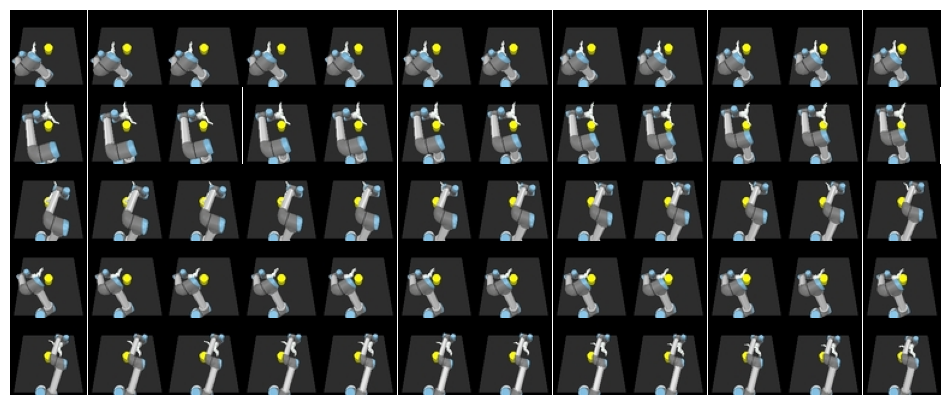

In [ ]:
plot_model_result(gt_list, f'gt', num_frames = gt_list.shape[2], n = n)

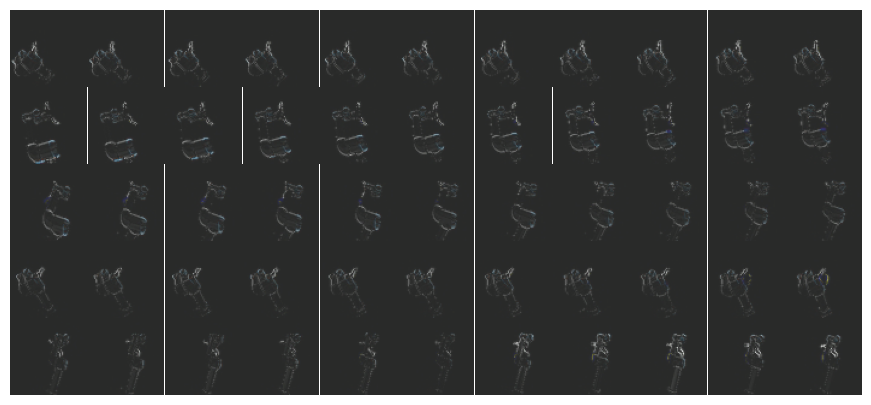

In [ ]:
gt_shift_list = gt_list[:, :, 1:, ...]
diff = (gt_shift_list - gt_list[:, :, 0:-1, ...]).abs()
plot_model_result(diff, f'gt-diff', num_frames = diff.shape[2], n = n)


#### VFP example, the last 10 frames are predicted by the model

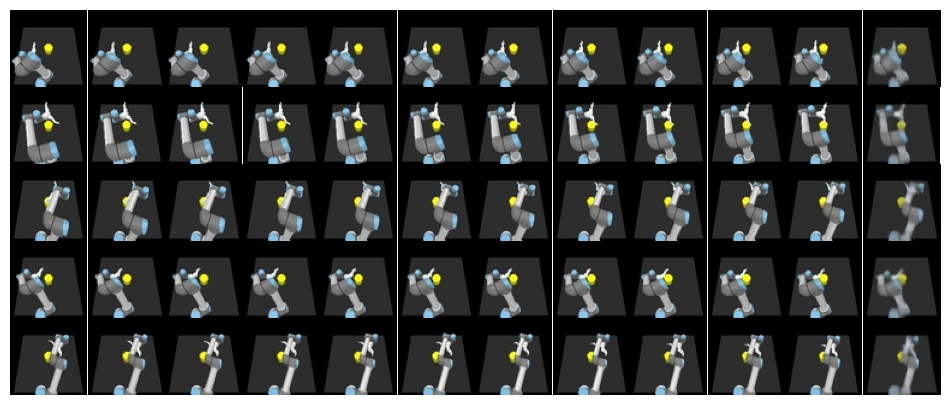

In [ ]:
plot_model_result(vfp_list, f'vfp', num_frames = vfp_list.shape[2], n = n)

#### VPE example, the first 10 frames are generated by the model

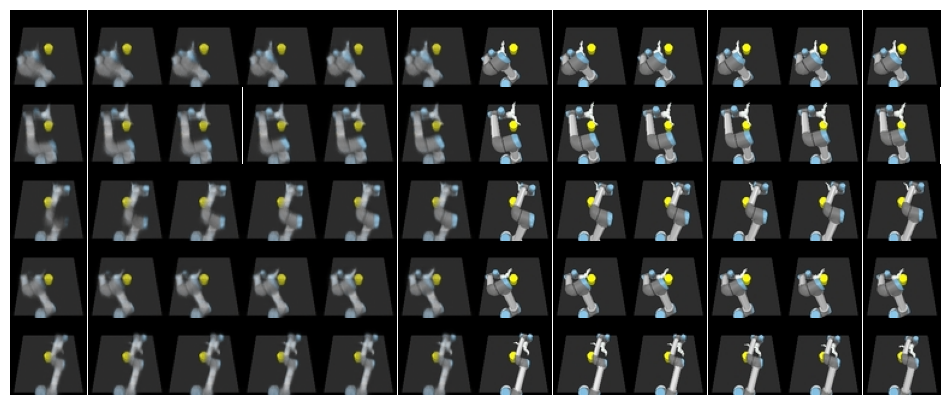

In [ ]:
plot_model_result(vpe_list, f'vpe', num_frames = vpe_list.shape[2], n = n)

#### VFI example, the middle 8 frames are interpolated by the model

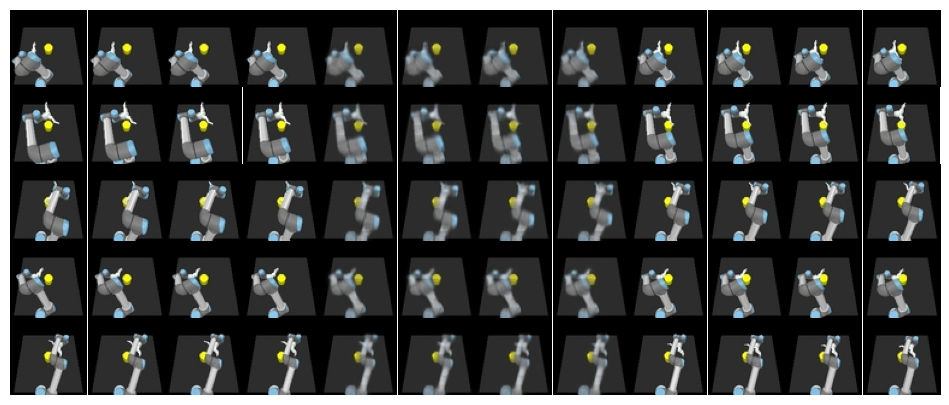

In [ ]:
plot_model_result(vfi_list, f'vfi', num_frames = vfi_list.shape[2], n = n)

#### VRC example, generate any frame at the coordinates specified by tp_list
Here, tp_list = [4, 5, 8, 9, 11, 12, 13, 17, 18, 19]

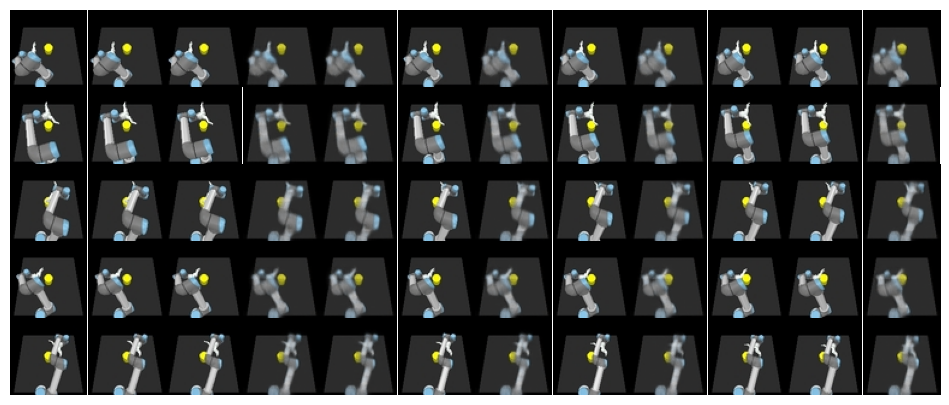

In [ ]:
plot_model_result(vrc_list, f'vrc', num_frames = vrc_list.shape[2], n = n)

#### Continuous generation. Not only VRC, but also generate frames at the coordinates which do not exist in the training dataset
Here, tp_list = [4, 4.25, 4.5, 5, 5.25, 5.5, 5.75, 8, 8.5, 9, 9.5, 11, 11.5, 12, 12.5, 13, 13.5, 17, 17.25, 17.5, 18, 18.5, 19]. For example, "5.25, 5.5, 5.75" are real number coordinates which do not exist in the training dataset. 

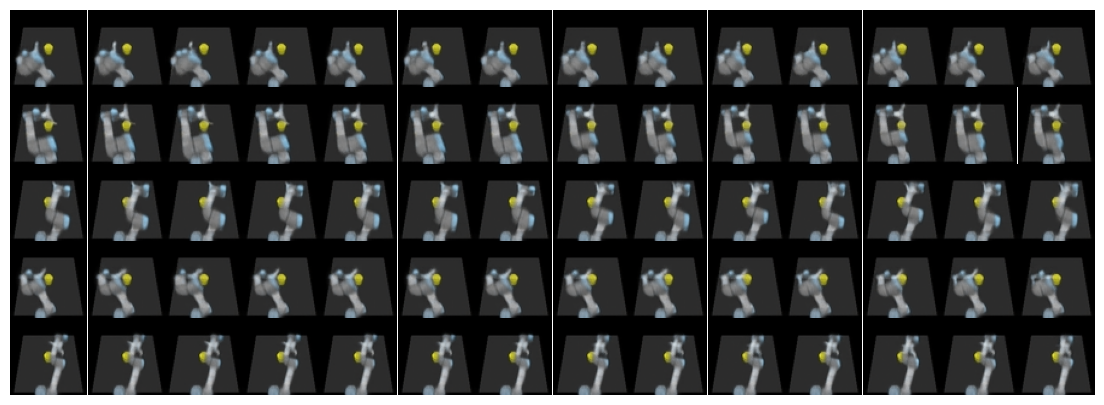

In [ ]:
plot_model_result(vrc_hfps_list, f'continuous', num_frames = vrc_hfps_list.shape[2], n = n)

In short, we can give any real number coordinate as the target coordinate (tp_list), as long as it is smaller than the maximum coordinate (num_past_frames+num_future_frames - 1) used during training.

#### We can visualize the difference image between adjacent frames to show that they are different frome each other

In [ ]:
vrc_hfps_shift_list = vrc_hfps_list[:, :, 1:, ...]
diff = (vrc_hfps_shift_list - vrc_hfps_list[:, :, 0:-1, ...]).abs()

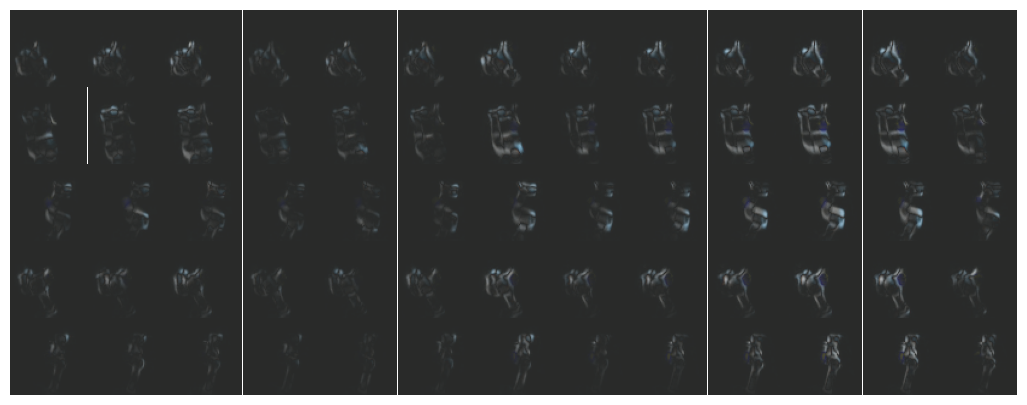

In [ ]:
plot_model_result(diff, 'continuous diff', num_frames = diff.shape[2], n = n)